# Adaptive PDE discretizations on cartesian grids

## Part : Additional tools
## Chapter : Non rectangular domains

This notebook illustrates the implementation of monotone schemes on non-rectangular domains, with Dirichlet boundary conditions. We show how to describe the domain, and adapt the finite differences.

In [10]:
import sys; sys.path.append("../..") # Allow imports from parent directory
from Miscellaneous import TocTools; TocTools.displayTOC('Domains','NonDiv')

[**Summary**](Summary.ipynb) of this series of notebooks. 

[**Main summary**](../Summary.ipynb), including the other volumes of this work. 


# Table of contents

  * [1. Geometric methods](#1.-Geometric-methods)
    * [1.1 Base domains, union, intersection, complement](#1.1-Base-domains,-union,-intersection,-complement)
    * [1.2 Level set function](#1.2-Level-set-function)
    * [1.3 Distance to the boundary in a given direction.](#1.3-Distance-to-the-boundary-in-a-given-direction.)
  * [2. Finite differences](#2.-Finite-differences)
    * [2.1 Upwind finite differences](#2.1-Upwind-finite-differences)
    * [2.2 Centered finite differences](#2.2-Centered-finite-differences)
    * [2.3 Second order finite differences](#2.3-Second-order-finite-differences)




**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Import the required libraries

In [118]:
from NumericalSchemes import Domain
from NumericalSchemes import AutomaticDifferentiation as ad
from NumericalSchemes import FiniteDifferences as fd

In [119]:
import scipy.linalg
import numpy as np
from matplotlib import pyplot as plt

In [120]:
import importlib
Domain = importlib.reload(Domain)
ad.reload_submodules()

## 1. Geometric methods

### 1.1 Base domains, union, intersection, complement

Define a ball and a box domain.

In [121]:
ball = Domain.Ball(np.array([0,0]))
box = Domain.Box([[0,1],[0,1]])

Their intersection, union, and relative complement.

In [122]:
cap = Domain.Intersection( (ball,box) )
cup = Domain.Union((ball,box))
compl = Domain.Complement(ball,box)

In [123]:
band = Domain.Band([1.,2.],[-2.,1.]) # Direction, bounds
triangle = Domain.ConvexPolygon(np.stack([[1,0],[0,1],[-1,-1]],axis=1))

In [124]:
doms = (ball,box,cap,compl,cup,band,triangle)
domNames = ("ball","box","cap","compl","cup","band","triangle")

Let us display the domains.

In [95]:
aX=np.linspace(-1.2,1.2)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

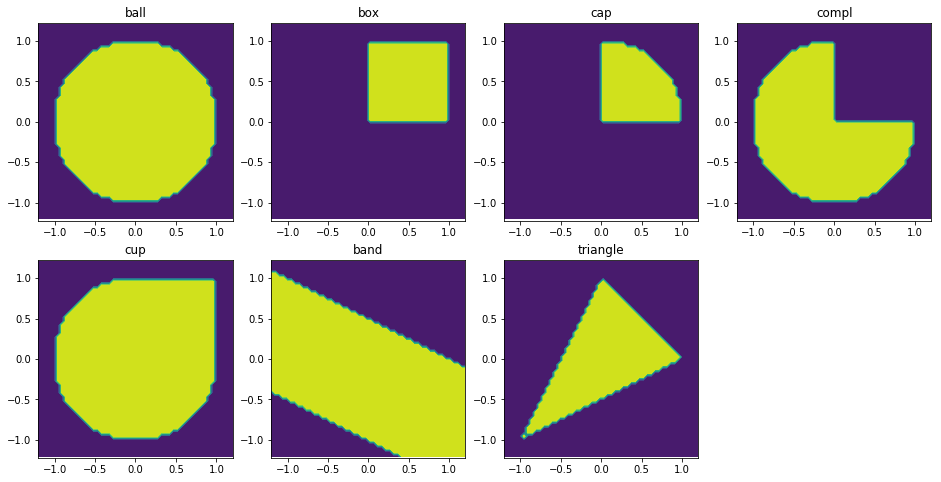

In [96]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    plt.contourf(*X,dom.contains(X))
    plt.title(name)
    plt.axis('equal')

### 1.2 Level set function

Each domain comes equipped with a level set function, that is negative inside, and positive outside.

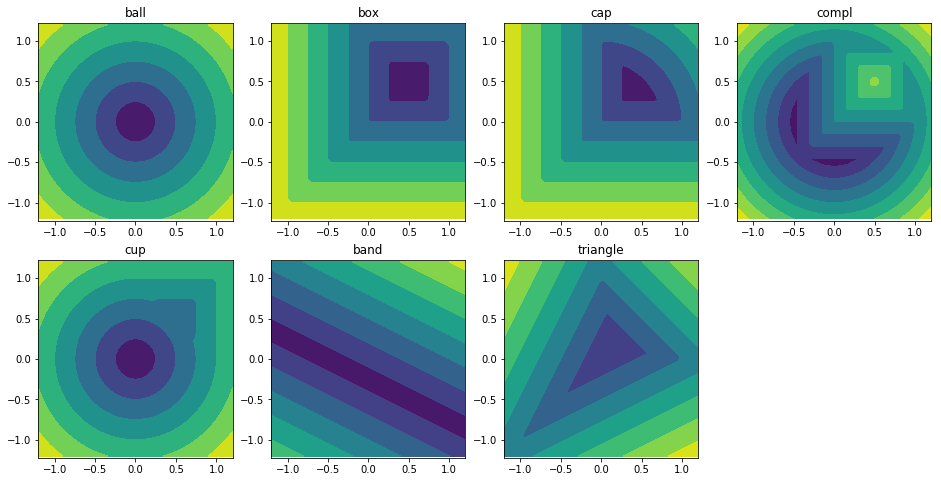

In [60]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    plt.contourf(*X,dom.level(X))
    plt.title(name)
    plt.axis('equal')

This level set function is in general different from the signed Euclidean distance to the boundary.  
If you do need the Euclidean distance function, you may need to consider solving an eikonal equation, or using an adequate computational geometry package.

### 1.3 Distance to the boundary in a given direction.

For the design of finite difference schemes, it is important to know the distance from a given point to the domain boundary in a given direction. This is referred to as the "free way" from $x$ in the direction $v$.

In [107]:
Domain = importlib.reload(Domain)
#ball = Domain.Ball(np.array([0,0]))
#box = Domain.Box([[0,1],[0,1]])
#cap = Domain.Intersection( (ball,box) )
#abox = Domain.AbsoluteComplement(box)
#aball = Domain.AbsoluteComplement(ball)
#compl = Domain.Complement(ball,box)
#cup = Domain.Union((ball,box))
#acup = Domain.Intersection((aball,abox))
band = Domain.Band([1.,2.],[-2.,1.]) # Direction, bounds

In [108]:
a,b = band.intervals(x,np.array([1,1.]))

NameError: name 'x' is not defined

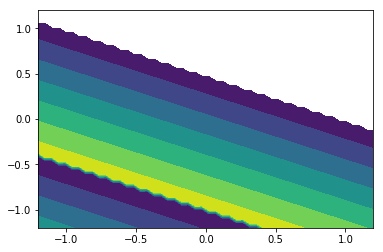

In [109]:
plt.contourf(*X,band.freeway(X,np.array([1.,1.])))

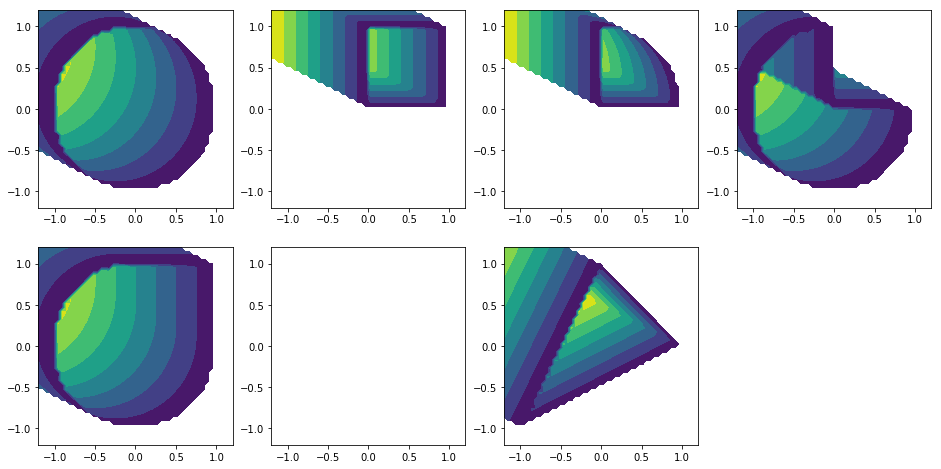

In [110]:
v=np.array([1,-0.5])
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,i+1)
    plt.contourf(*X,dom.freeway(X,v))

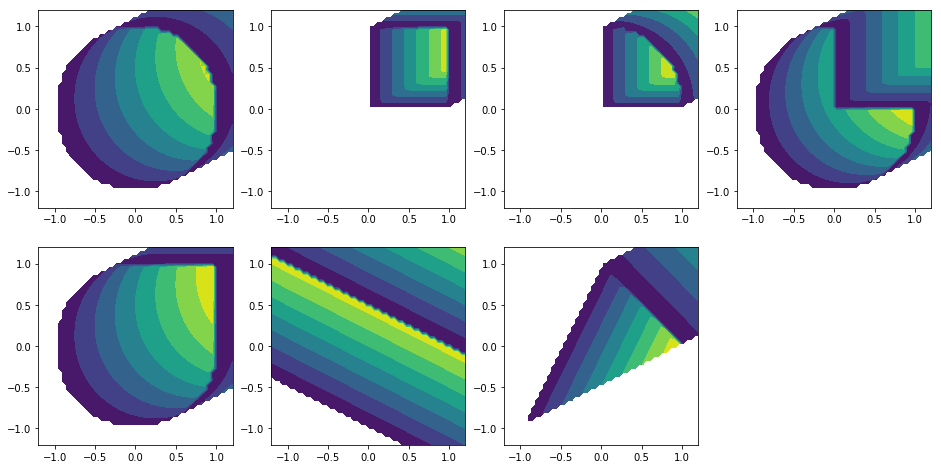

In [125]:
v=np.array([-1,-0.5])
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,i+1)
    plt.contourf(*X,dom.freeway(X,v))

In [126]:
x=np.array([1,-1])
triangle.intervals(x,v)
[dom.intervals(x,v) for dom in triangle.doms]

[(array([inf]), array([inf])),
 (array([-0.66666667]), array([inf])),
 (array([-inf]), array([2.66666667]))]

## 2. Finite differences

In [299]:
Domain = importlib.reload(Domain)
ball = Domain.Ball(np.array([0,0]))
box = Domain.Box([[0,1],[0,1]])
cup = Domain.Union((ball,box))

In [307]:
def bc(x): return x[0]+2*x[1]
cond = Domain.Dirichlet(cup,bc,grid=X)
h=aX[1]-aX[0]

### 2.1 Upwind finite differences

In [308]:
u = bc(X)
interior = cond.dom.contains(1.1*X)
u[np.logical_not(interior)]=np.nan

In [309]:
du = cond.DiffUpwind(u,(1,0),h)

In [310]:
du[interior].max(),du[interior].min()

(1.0000000000000142, 0.9999999999999929)

In [311]:
du = cond.DiffUpwind(u,np.eye(2).astype(int),h)

In [319]:
du[0,interior].max(),du[0,interior].min()

(1.000000000000007, 0.9999999999999929)

In [313]:
du[1,interior].max(),du[1,interior].min()

(2.000000000000014, 1.9999999999999858)

### 2.2 Centered finite differences

In [269]:
du = cond.DiffCentered(u,(1,0),h)

In [270]:
du[interior].max(),du[interior].min()

(1.000000000000007, 0.9999999999999982)

In [314]:
du = cond.DiffCentered(u,np.eye(2).astype(int),h)

In [318]:
du[0,interior].max(),du[0,interior].min()

(1.000000000000007, 0.9999999999999929)

In [317]:
du[1,interior].max(),du[1,interior].min()

(2.000000000000014, 1.9999999999999953)

### 2.3 Second order finite differences

In [271]:
d2u = cond.Diff2(u,(1,0),h)

In [272]:
d2u[interior].max(),d2u[interior].min()

(3.410605131648481e-13, -3.410605131648481e-13)

In [321]:
d2u = cond.Diff2(u,np.eye(2).astype(int),h)

In [323]:
d2u[1,interior].max(),d2u[1,interior].min()

(5.684341886080801e-13, -5.684341886080801e-13)

In [322]:
d2u[1,interior].max(),d2u[1,interior].min()

(5.684341886080801e-13, -5.684341886080801e-13)